<a href="https://colab.research.google.com/github/Shaurya016/Celebal-Assignment-05/blob/main/House%20Price%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# 📁 STEP 1: Upload CSV files
from google.colab import files

# Upload train.csv, test.csv, sample_submission.csv
uploaded = files.upload()



Saving sample_submission.csv to sample_submission (1).csv


In [7]:
# 📁 STEP 1: Upload CSV files
from google.colab import files

# Upload train.csv, test.csv, sample_submission.csv
uploaded = files.upload()


Saving train.csv to train.csv


In [8]:
# 📁 STEP 1: Upload CSV files
from google.colab import files

# Upload train.csv, test.csv, sample_submission.csv
uploaded = files.upload()


Saving test.csv to test.csv


In [9]:
# Verify if all files are there
import os
print(os.listdir())


['.config', 'test.csv', 'sample_submission.csv', 'train.csv', 'sample_submission (1).csv', 'sample_data']


In [10]:
# 📦 STEP 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [11]:
# 📊 STEP 3: Load the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (1460, 81)
Test shape: (1459, 80)


In [12]:
# 🧹 STEP 4: Save and remove IDs + target
train_ID = train['Id']
test_ID = test['Id']
y = train['SalePrice']

train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Combine for preprocessing
all_data = pd.concat([train, test], axis=0)
print(f"Combined data shape: {all_data.shape}")


Combined data shape: (2919, 79)


In [13]:
# 🔍 STEP 5: Missing Value Check
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n", missing)


Columns with missing values:
 PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64


In [14]:
# 🛠️ STEP 6: Fill missing values

# Fill 'None' for categorical NA
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType']

for col in none_cols:
    all_data[col] = all_data[col].fillna("None")

# Fill 0 for numeric NA where NA means "no such feature"
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea']

for col in zero_cols:
    all_data[col] = all_data[col].fillna(0)

# Fill with mode for categorical
mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'SaleType', 'Functional']

for col in mode_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Check final NA
print("Remaining missing values:", all_data.isnull().sum().sum())


Remaining missing values: 488


In [15]:
# ✨ STEP 7: Feature Engineering

# New Total square footage
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Total Bathrooms
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

# Age of house and remodel
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']

# Garage age (careful with zeros!)
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']
all_data['GarageAge'] = all_data['GarageAge'].replace(2025, 0)  # Replacing future values (from missing GarageYrBlt)

# Drop original years (optional)
all_data.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

print("Feature engineering done. Shape:", all_data.shape)


Feature engineering done. Shape: (2919, 81)


In [16]:
# 🔢 STEP 8: Encode Categorical Features
all_data = pd.get_dummies(all_data)
print("Shape after one-hot encoding:", all_data.shape)


Shape after one-hot encoding: (2919, 304)


In [17]:
# 🔄 STEP 9: Split Combined Data Back
X = all_data.iloc[:train.shape[0], :]
X_test = all_data.iloc[train.shape[0]:, :]

print(f"Train features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")


Train features shape: (1460, 304)
Test features shape: (1459, 304)


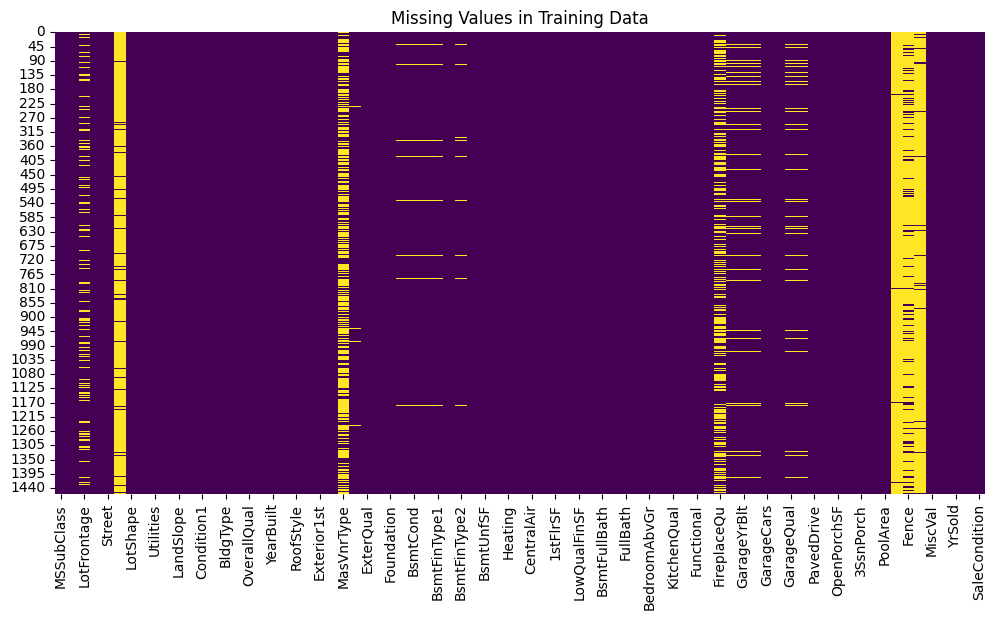

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing values before imputation
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Training Data")
plt.show()


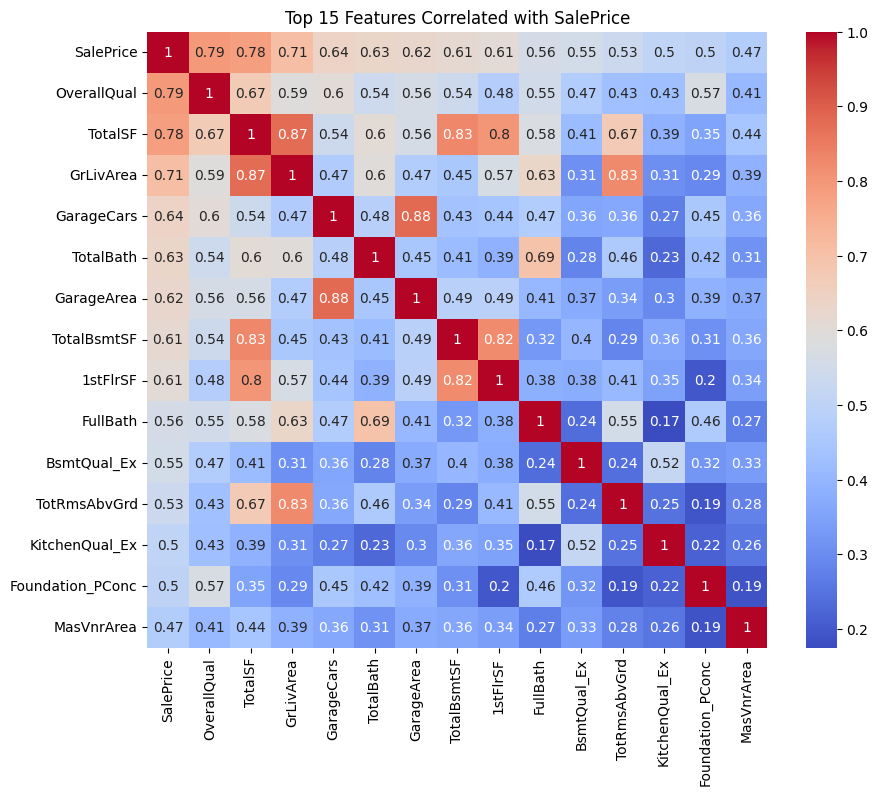

In [19]:
# Add SalePrice back temporarily to calculate correlation
temp = pd.concat([X, y], axis=1)

# Plot heatmap of top correlated features
corr = temp.corr()
top_corr = corr['SalePrice'].sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.heatmap(temp[top_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top 15 Features Correlated with SalePrice")
plt.show()


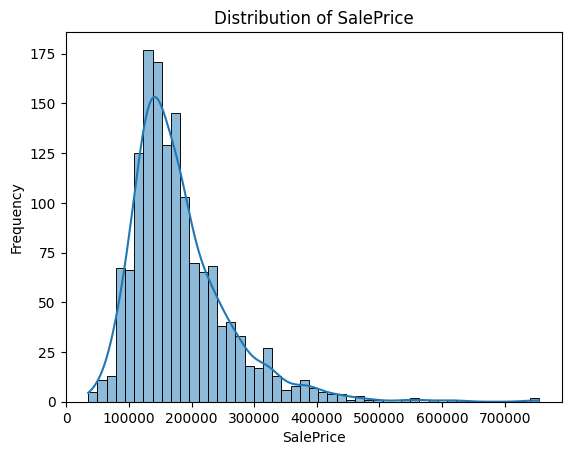

In [20]:
sns.histplot(y, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


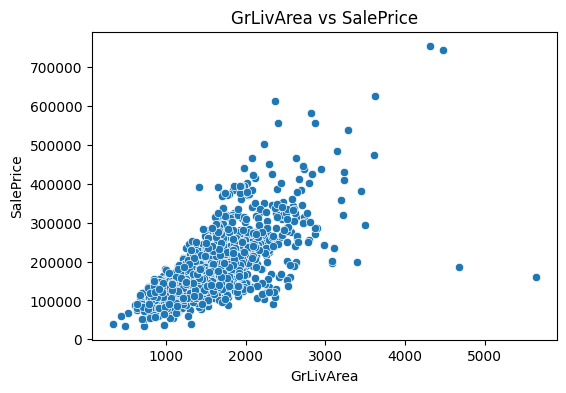

In [21]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=X['GrLivArea'], y=y)
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


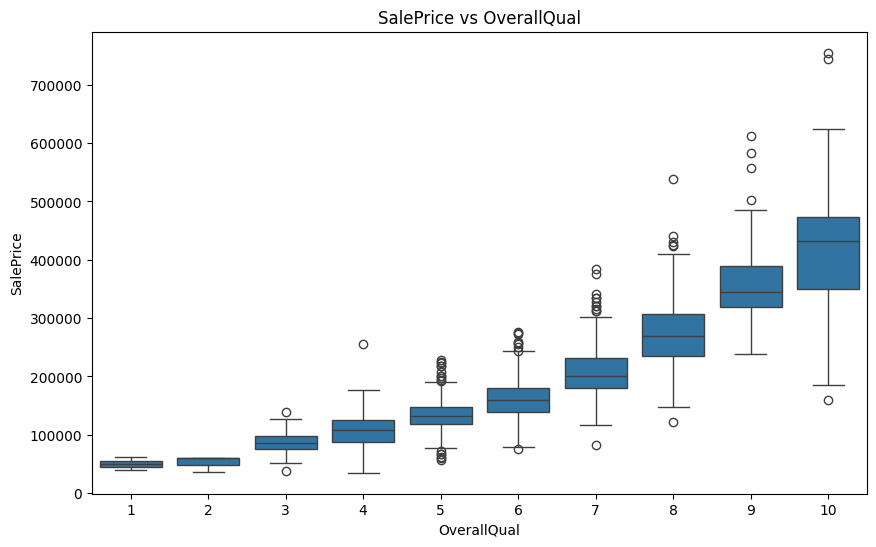

In [22]:
# Add target back temporarily for plotting
train_plot = train.copy()
train_plot['SalePrice'] = y

plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_plot)
plt.title("SalePrice vs OverallQual")
plt.show()
